In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime
import os
import math

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
pd.options.display.max_columns = None

### Strategia del VA

In [3]:
# Dataset dal 28-04-2013 al 13-12-2023 con granularità di 1 giorno
# dati = pd.read_csv('bitcoin_data.csv')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati

# Dataset dal 17-09-2014 al 24-04-2024 con granularità di 1 giorno
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati.rename(columns={'Date':'Timestamp', 'Close':'Price'}, inplace=True)
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati = dati[['Timestamp', 'Price']]
dati


# Dataset con granularità di 1 minuto
# dati = pd.read_csv('Bitcoin dal 01 01 2012 al 31 03 2021 con granularità al minuto (già inputato).csv')
# dati = dati.drop(['Timestamp'], axis=1)
# dati['Data'] = pd.to_datetime(dati['Data'])
# dati.rename(columns={'Data':'Timestamp', 'Close':'Price'}, inplace=True)
# dati

,Timestamp,Price
0,2014-09-17 00:00:00+00:00,355.957367
1,2014-09-18 00:00:00+00:00,328.539368
2,2014-09-19 00:00:00+00:00,307.761139
3,2014-09-20 00:00:00+00:00,318.758972
4,2014-09-21 00:00:00+00:00,310.632446
...,...,...
3503,2024-04-20 00:00:00+00:00,59876.710938
3504,2024-04-21 00:00:00+00:00,60956.074219
3505,2024-04-22 00:00:00+00:00,60919.242188
3506,2024-04-23 00:00:00+00:00,62729.296875


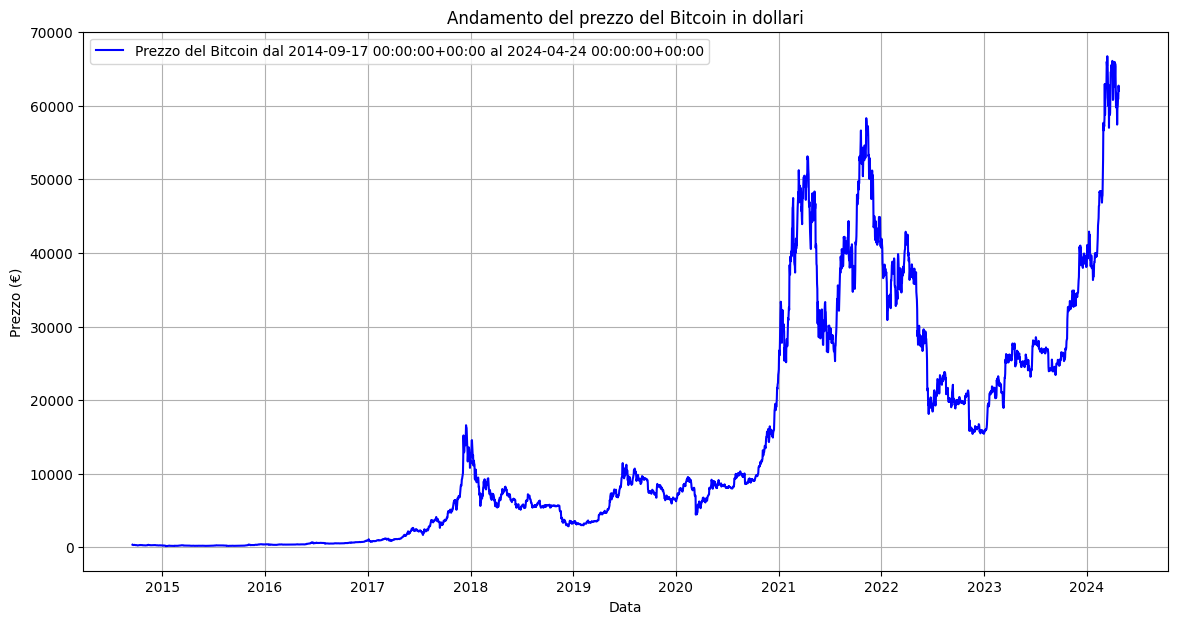

In [4]:
x = dati['Timestamp']
y = dati['Price']

plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"Prezzo del Bitcoin dal {str(x.iloc[0])} al {str(x.iloc[-1])}", color='blue')
plt.title('Andamento del prezzo del Bitcoin in dollari')
plt.xlabel('Data')
plt.ylabel('Prezzo (€)')
plt.legend()
plt.grid(True)
plt.show()

<h6> Scelta periodo </h6>

In [5]:
data_inizio = '2020-03-01'
data_fine = '2021-03-01'

In [6]:
data1 = datetime.strptime(data_inizio, '%Y-%m-%d')
data2 = datetime.strptime(data_fine, '%Y-%m-%d')
lunghezza_periodo = (data2-data1).days
lunghezza_periodo

365

In [7]:
dati[dati['Timestamp'] == data_inizio]

,Timestamp,Price
1992,2020-03-01 00:00:00+00:00,7748.164551


In [8]:
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_inizio

1992

In [9]:
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
indice_fine

2357

In [10]:
dati = dati[indice_inizio:indice_fine + 1]

In [11]:
dati = dati.reset_index(drop=True)

In [12]:
dati

,Timestamp,Price
0,2020-03-01 00:00:00+00:00,7748.164551
1,2020-03-02 00:00:00+00:00,7959.358398
2,2020-03-03 00:00:00+00:00,7862.485352
3,2020-03-04 00:00:00+00:00,7861.055176
4,2020-03-05 00:00:00+00:00,8089.786133
...,...,...
361,2021-02-25 00:00:00+00:00,38735.164062
362,2021-02-26 00:00:00+00:00,38385.910156
363,2021-02-27 00:00:00+00:00,38260.480469
364,2021-02-28 00:00:00+00:00,37332.503906


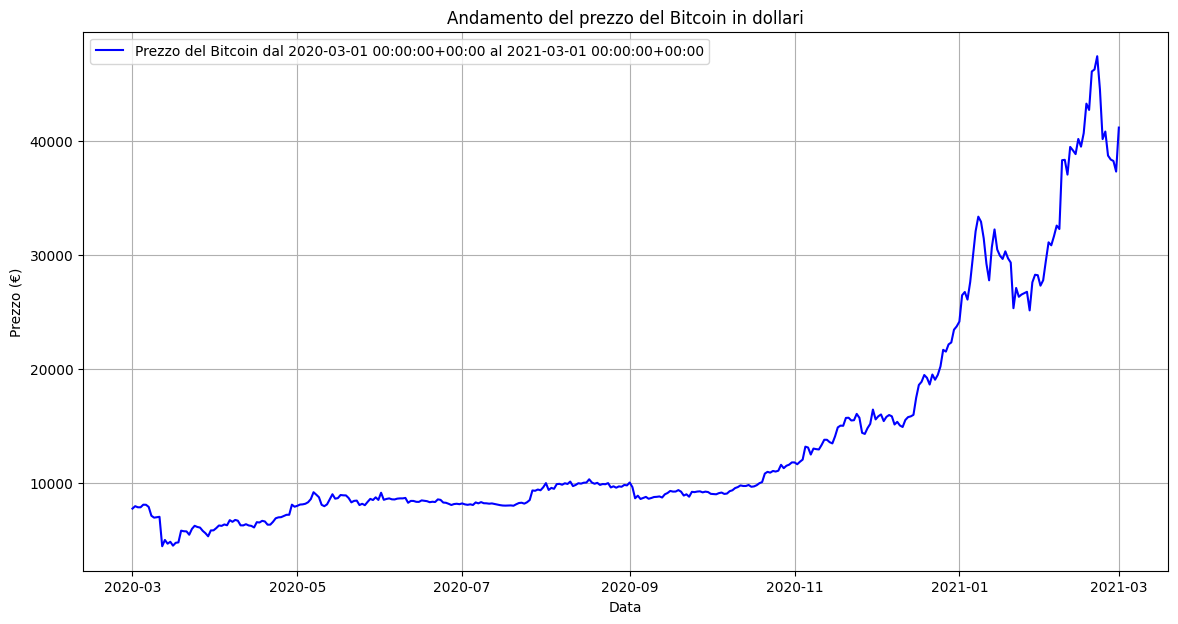

In [13]:
x = dati['Timestamp']
y = dati['Price']

plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"Prezzo del Bitcoin dal {str(x.iloc[0])} al {str(x.iloc[-1])}", color='blue')
plt.title('Andamento del prezzo del Bitcoin in dollari')
plt.xlabel('Data')
plt.ylabel('Prezzo (€)')
plt.legend()
plt.grid(True)
plt.show()

<h6> Inizializzazione variabili </h6>

In [14]:
# Variabili
strategia_giacomo = False
perc_ritiro = 1
tempo_controllo = 220 # Ogni quanti giorni controllo se c'è da ritirare l'eccesso dei soldi rispetto all'investimento_base
fare_prima_VA = True # se è True, viene fatto prima (eventualmente) il value averaging e poi si ritira (eventualmente) la differenza tra i dollari posseduti su YP e l'investimento iniziale, altrimenti viceversa

strategia_VA = True
investimento_base = 0 # Quanti € di bitcoin compro il primo giorno; è anche la soglia per sapere se ritirare l'eccesso dei soldi
timeframe = 1 # Ogni quanti giorni faccio in modo di comprare (o eventualmente vendere se vendita_VA = True) bitcoin in modo che il totale valga quanto stabilito dall'obiettivo di quel giorno (ad esempio potrei avere come obiettivo il secondo giorno 200€, il terzo giorno 300€ e così via)
# quantità_VA = 10 # ogni timeframe giorni compro bitcoin in € pari al valore che serve per avere quantità_VA € in più rispetto alla volta precedente (in particolare timeframe giorni prima); quindi inizialmente ho bitcoin con valore quantità_VA €, poi timeframe giorni dopo ne avrò in modo che valgano 2*quantità_VA €, poi timeframe giorni dopo avrò 3*quantità_VA € e così via
vendita_VA = False # se è True, significa che è possibile anche che si venda nel caso in cui il valore obiettivo del portafoglio di quel giorno debba essere inferiore a quello che in realtà ho già; se invece è False, in un caso del genere non si fa niente

In [15]:
def bitcoin_in_dollari(bitcoin, prezzo_bitcoin):
    return bitcoin * prezzo_bitcoin

def dollari_in_bitcoin(dollari, prezzo_bitcoin):
    return dollari / prezzo_bitcoin

# Tenere conto che prima facevo un acquisto pari a quantità_VA ogni timeframe giorni, che qui equivarrebbe a un obiettivo quantità_VA*t/timeframe; se invece volessi aumentare l'obiettivo di quantità_VA ogni giorno, facendo però il VA solo ogni timeframe giorni, dovrei scrivere quantità_VA*t come obiettivo
slittamento = 1 # Mi serve nel caso in cui voglio che l'obiettivo sia il prezzo stesso slittato di una certa quantità, ad esempio il prezzo del giorno precedente; se non viene usato, bisogna lasciarlo uguale a 1 per fare in modo che nella simulazione i calcoli partano dal giorno 1
def calcola_obiettivo(t):
    quanti = 30
    massimo = max(dati['Price'].iloc[:t])
    if t > quanti:
         massimo = max(dati['Price'].iloc[t-quanti:t])
    
    rapporto = massimo / (dati['Price'][t] * bitcoin_YP)
    return 10*t/timeframe #(massimo - dati['Price'][t]) / rapporto

    # return bitcoin_YP_in_dollari + 100 # Questo serve per tornare a un PAC tradizionale (DCA) di 100 ogni timeframe giorni

    # return 0.1*dati['Price'][0]

def calcola_prezzo(t):
    global pr_prec
    if t == 0:
        pr = 60000 + random.randint(-1000, 1000)
        pr_prec = pr
    else:
        pr = pr_prec + random.randint(-1000, 1000)
    return 500 + 20*math.sin(2*math.pi *t/4)

In [16]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati[:10]

,Timestamp,Price
0,2020-03-01 00:00:00+00:00,500.0
1,2020-03-02 00:00:00+00:00,520.0
2,2020-03-03 00:00:00+00:00,500.0
3,2020-03-04 00:00:00+00:00,480.0
4,2020-03-05 00:00:00+00:00,500.0
5,2020-03-06 00:00:00+00:00,520.0
6,2020-03-07 00:00:00+00:00,500.0
7,2020-03-08 00:00:00+00:00,480.0
8,2020-03-09 00:00:00+00:00,500.0
9,2020-03-10 00:00:00+00:00,520.0


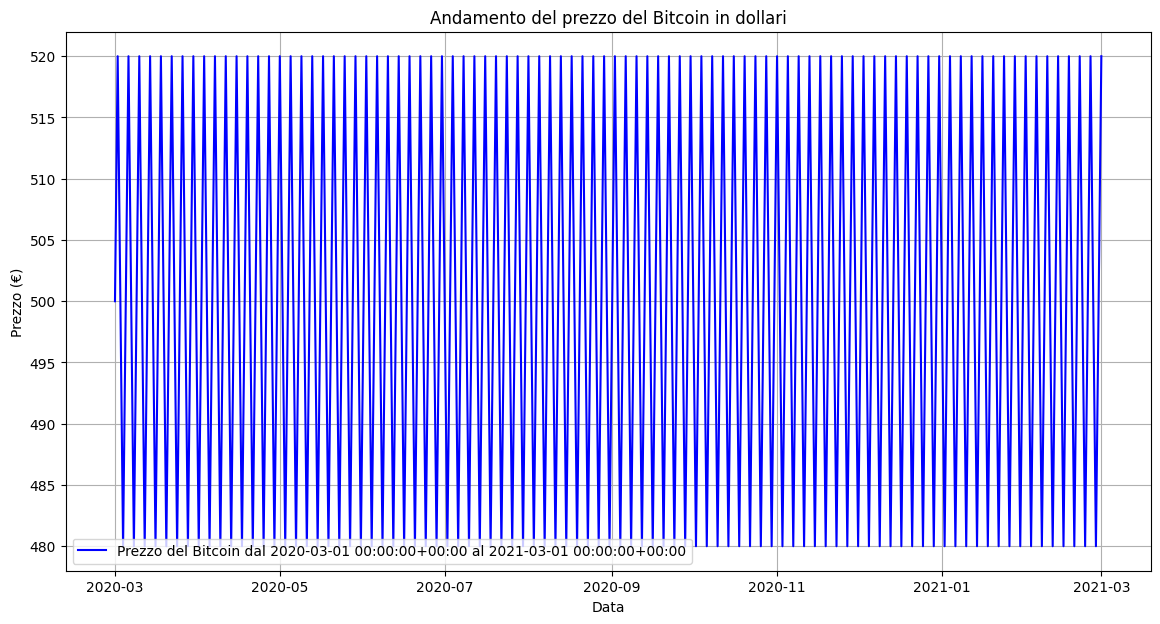

In [17]:
x = dati['Timestamp']
y = dati['Price']

plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"Prezzo del Bitcoin dal {str(x.iloc[0])} al {str(x.iloc[-1])}", color='blue')
plt.title('Andamento del prezzo del Bitcoin in dollari')
plt.xlabel('Data')
plt.ylabel('Prezzo (€)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Calcolo la media dei valori assoluti delle variazioni percentuali
variazioni_percentuali = (dati['Price'].diff() / dati['Price'].shift() - 1).abs()
media_variazioni_percentuali = variazioni_percentuali.mean()
print(f"Media dei valori assoluti delle variazioni percentuali: {media_variazioni_percentuali*100:.2f}%")

Media dei valori assoluti delle variazioni percentuali: 99.91%


In [19]:
variazioni_percentuali

0           NaN
1      0.960000
2      1.038462
3      1.040000
4      0.958333
         ...   
361    0.960000
362    1.038462
363    1.040000
364    0.958333
365    0.960000
Name: Price, Length: 366, dtype: float64

In [20]:
# Calcolo la deviazione standard delle variazioni percentuali
deviazione_standard_variazioni_percentuali = variazioni_percentuali.std()
print(f"Deviazione standard delle variazioni percentuali: {deviazione_standard_variazioni_percentuali*100:.2f}%")

Deviazione standard delle variazioni percentuali: 4.01%


In [21]:
tabella_finale = dati.copy()

dollari_in_banca = 100000
deposito_iniziale = 1000
bitcoin_YP_iniziali = 0
deposito_YP = 0
bitcoin_YP = bitcoin_YP_iniziali
bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, dati['Price'][0])
perc_tassa_acquisto = 0.002
liquidità_ist = 0
liquidità_cumulativa = 0
ricarica_cumulativa = 0
obiettivo_cumulativo = 0
tasse_pagate_ist = 0
tasse_pagate = 0

tabella_finale.rename(columns={'Timestamp': 'Data'}, inplace=True)
tabella_finale.rename(columns={'Price': 'Prezzo bitcoin in €'}, inplace=True)

# Creo delle colonne con dei valori solo allo scopo di creare queste colonne, per ora non sono importanti i valori
tabella_finale['Deposito su YP in €'] = deposito_YP
tabella_finale['Deposito su YP + liquidità cumulativa in €'] = deposito_YP + liquidità_cumulativa
tabella_finale['Bitcoin su YP'] = bitcoin_YP
tabella_finale['Bitcoin su YP in €'] = bitcoin_YP_in_dollari
tabella_finale['Ritiro per strategia Giacomo in €'] = 0
tabella_finale['Soldi in banca in €'] = dollari_in_banca
tabella_finale['Vendita effettuata'] = False
tabella_finale['Liquidità istantanea'] = liquidità_ist
tabella_finale['Liquidità cumulativa'] = liquidità_cumulativa
# tabella_finale['Obiettivo'] = '-' # La popolo successivamente
tabella_finale['Obiettivo "cumulativo"'] = 0 # La popolo successivamente
tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in €'] = 0
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
tabella_finale['Ricarica istantanea per VA'] = 0
tabella_finale['Ricarica cumulativa per VA'] = ricarica_cumulativa
tabella_finale['Tasse pagate istantanee'] = tasse_pagate_ist
tabella_finale['Tasse pagate cumulative'] = tasse_pagate

prezzo_attuale = tabella_finale['Prezzo bitcoin in €'][0]

In [22]:
# Ricarica iniziale del deposito di YP
dollari_in_banca -= deposito_iniziale
deposito_YP += deposito_iniziale

In [23]:
# Acquisto bitcoin su YP per la prima volta, prima di cominciare il ciclo con le mie strategie
deposito_YP -= investimento_base * (1 + perc_tassa_acquisto)
bitcoin_YP += dollari_in_bitcoin(investimento_base, prezzo_attuale)
# print('Prezzo attuale:', prezzo_attuale)
# print('bitcoin_YP', bitcoin_YP)
bitcoin_YP_in_dollari += investimento_base
tasse_pagate_ist = perc_tassa_acquisto * investimento_base
tasse_pagate += perc_tassa_acquisto * investimento_base
# bitcoin_YP_in_dollari += investimento_base # In realtà lo faccio già dopo, durante il ciclo for

tabella_finale['Deposito su YP in €'][0] = deposito_YP
tabella_finale['Deposito su YP + liquidità cumulativa in €'][0] = deposito_YP + liquidità_cumulativa
tabella_finale['Bitcoin su YP'][0] = bitcoin_YP
tabella_finale['Bitcoin su YP in €'][0] = bitcoin_YP_in_dollari
tabella_finale['Ritiro per strategia Giacomo in €'][0] = 0
tabella_finale['Soldi in banca in €'] = dollari_in_banca
tabella_finale['Vendita effettuata'][0] = False
tabella_finale['Liquidità istantanea'][0] = liquidità_ist
tabella_finale['Liquidità cumulativa'][0] = liquidità_cumulativa
# tabella_finale['Obiettivo'][0] = '-' # La popolo successivamente
tabella_finale['Obiettivo "cumulativo"'][0] = 0 # La popolo successivamente
tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in €'][0] = '-'
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][0] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
tabella_finale['Ricarica istantanea per VA'][0] = 0
tabella_finale['Ricarica cumulativa per VA'][0] = ricarica_cumulativa
tabella_finale['Tasse pagate istantanee'][0] = tasse_pagate_ist
tabella_finale['Tasse pagate cumulative'][0] = tasse_pagate

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_127744\1384288026.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tabella_finale['Deposito su YP in €'][0] = deposito_YP
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_127744\1384288026

In [24]:
prezzo_attuale

500.0

<h6> Simulazione </h6>

In [25]:
for t in range(slittamento, len(dati)): # Se nell'obiettivo c'è lo slittamento devo partire da un po' dopo il primo dato
        # print(tasse_pagate)
        liquidità_ist = 0
        prezzo_attuale = calcola_prezzo(t) #tabella_finale['Prezzo bitcoin in €'][t]
        # print('Prezzo attuale:', prezzo_attuale)
        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
        # print(bitcoin_YP_in_dollari)
        obiettivo_precedente = 0

        if fare_prima_VA:
                if t % timeframe == 0 and strategia_VA: # Se è un giorno in cui voglio comprare altri bitcoin
                        # obiettivo = quantità_VA * t // timeframe
                        obiettivo = calcola_obiettivo(t)
                        obiettivo_cumulativo = obiettivo
                        # print('Obiettivo:', obiettivo)
                        ricarica = obiettivo - bitcoin_YP_in_dollari
                        # print('Ricarica:', ricarica)
                        # print('Bitcoin YP', bitcoin_YP)
                        # print('Bitcoin YP in €', bitcoin_YP_in_dollari)
                        variazione_obiettivo = obiettivo - obiettivo_precedente
                        obiettivo_precedente = obiettivo
                        liquidità = variazione_obiettivo - ricarica
                        if liquidità >= 0 and liquidità <= variazione_obiettivo:
                                if deposito_YP >= liquidità: # correzzione aggiunta tardi
                                        deposito_YP -= liquidità
                                        liquidità_ist = liquidità
                                        liquidità_cumulativa += liquidità
                        elif liquidità > variazione_obiettivo:
                                if deposito_YP >= variazione_obiettivo: # correzzione aggiunta tardi
                                        deposito_YP -= variazione_obiettivo
                                        liquidità_ist = variazione_obiettivo
                                        liquidità_cumulativa += variazione_obiettivo
                        # Questo else è superfluo perchè il fondo liquidità è già 0 di base, inoltre aggiungere 0 è come non fare nulla, ma lo lascio per chiarezza
                        # else:
                        #         liquidità_ist = 0
                        #         liquidità_cumulativa += 0

                        if ricarica >= 0:
                                # Se non ci sono abbastanza soldi nel deposito, prendo tutto dal deposito e quello che manca dalla liquidità accumulata
                                if ricarica * (1 + perc_tassa_acquisto) <= deposito_YP:
                                        deposito_YP -= ricarica * (1 + perc_tassa_acquisto)
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                else:
                                        liquidità_cumulativa -= ricarica * (1 + perc_tassa_acquisto) - deposito_YP
                                        deposito_YP = 0
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale)
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                                ricarica_cumulativa += ricarica
                                tabella_finale['Ricarica istantanea per VA'][t] = ricarica
                        elif vendita_VA:
                                tabella_finale['Vendita effettuata'][t] = True
                                deposito_YP -= ricarica * (1 - perc_tassa_acquisto) # aumenta il deposito perchè qui ricarica è negativa; poi ci sono le tasse anche sulla vendita
                                tasse_pagate_ist = -perc_tassa_acquisto * ricarica
                                tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                tasse_pagate -= perc_tassa_acquisto * ricarica # anche qui è importante ricordare il "-" perchè ricarica è negativa
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale) # calano perchè qui ricarica è negativa
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                        # tabella_finale['Obiettivo'][t] = obiettivo

                if t % tempo_controllo == 0 and strategia_giacomo:
                        if bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) > investimento_base:
                                ritiro_in_dollari = (bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) - investimento_base) * perc_ritiro
                                tabella_finale['Ritiro per strategia Giacomo in €'][t] = ritiro_in_dollari
                                deposito_YP += ritiro_in_dollari * (1 - perc_tassa_acquisto)
                                tasse_pagate_ist = perc_tassa_acquisto * ritiro_in_dollari
                                tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                tasse_pagate += perc_tassa_acquisto * ritiro_in_dollari
                                bitcoin_YP -= dollari_in_bitcoin(ritiro_in_dollari, prezzo_attuale)
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                        
        else:

                if t % tempo_controllo == 0 and strategia_giacomo:
                        if bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) > investimento_base:
                                ritiro_in_dollari = (bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) - investimento_base) * perc_ritiro
                                tabella_finale['Ritiro per strategia Giacomo in €'][t] = ritiro_in_dollari
                                deposito_YP += ritiro_in_dollari * (1 - perc_tassa_acquisto)
                                tasse_pagate_ist = perc_tassa_acquisto * ritiro_in_dollari
                                tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                tasse_pagate += perc_tassa_acquisto * ritiro_in_dollari
                                bitcoin_YP -= dollari_in_bitcoin(ritiro_in_dollari, prezzo_attuale)
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                

                if t % timeframe == 0 and strategia_VA: # Se è un giorno in cui voglio comprare altri bitcoin
                        # obiettivo = quantità_VA * t // timeframe
                        obiettivo = calcola_obiettivo(t)
                        obiettivo_cumulativo = obiettivo
                        # print('Obiettivo:', obiettivo)
                        ricarica = obiettivo - bitcoin_YP_in_dollari
                        # print('Ricarica:', ricarica)
                        # print('Bitcoin YP', bitcoin_YP)
                        # print('Bitcoin YP in €', bitcoin_YP_in_dollari)
                        variazione_obiettivo = obiettivo - obiettivo_precedente
                        obiettivo_precedente = obiettivo
                        liquidità = variazione_obiettivo - ricarica
                        if liquidità >= 0 and liquidità <= variazione_obiettivo:
                                if deposito_YP >= liquidità: # correzzione aggiunta tardi
                                        deposito_YP -= liquidità
                                        liquidità_ist = liquidità
                                        liquidità_cumulativa += liquidità
                        elif liquidità > variazione_obiettivo:
                                if deposito_YP >= variazione_obiettivo: # correzzione aggiunta tardi
                                        deposito_YP -= variazione_obiettivo
                                        liquidità_ist = variazione_obiettivo
                                        liquidità_cumulativa += variazione_obiettivo
                        # Questo else è superfluo perchè il fondo liquidità è già 0 di base, inoltre aggiungere 0 è come non fare nulla, ma lo lascio per chiarezza
                        # else:
                        #         liquidità_ist = 0
                        #         liquidità_cumulativa += 0

                        if ricarica >= 0:
                                # Se non ci sono abbastanza soldi nel deposito, prendo tutto dal deposito e quello che manca dalla liquidità accumulata
                                if ricarica * (1 + perc_tassa_acquisto) <= deposito_YP:
                                        deposito_YP -= ricarica * (1 + perc_tassa_acquisto)
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                else:
                                        liquidità_cumulativa -= ricarica * (1 + perc_tassa_acquisto) - deposito_YP
                                        deposito_YP = 0
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale)
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                                ricarica_cumulativa += ricarica
                                tabella_finale['Ricarica istantanea per VA'][t] = ricarica
                        elif vendita_VA:
                                tabella_finale['Vendita effettuata'][t] = True
                                deposito_YP -= ricarica * (1 - perc_tassa_acquisto) # aumenta il deposito perchè qui ricarica è negativa; poi ci sono le tasse anche sulla vendita
                                tasse_pagate_ist = -perc_tassa_acquisto * ricarica
                                tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                tasse_pagate -= perc_tassa_acquisto * ricarica # anche qui è importante ricordare il "-" perchè ricarica è negativa
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale) # calano perchè qui ricarica è negativa
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                        # tabella_finale['Obiettivo'][t] = obiettivo

        tabella_finale['Deposito su YP in €'][t] = deposito_YP
        tabella_finale['Deposito su YP + liquidità cumulativa in €'][t] = deposito_YP + liquidità_cumulativa
        tabella_finale['Bitcoin su YP'][t] = bitcoin_YP
        tabella_finale['Bitcoin su YP in €'][t] = bitcoin_YP_in_dollari
        tabella_finale['Liquidità istantanea'][t] = liquidità_ist
        tabella_finale['Liquidità cumulativa'][t] = liquidità_cumulativa
        tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][t] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
        tabella_finale['Ricarica cumulativa per VA'][t] = ricarica_cumulativa
        tabella_finale['Tasse pagate cumulative'][t] = tasse_pagate
        tabella_finale['Obiettivo "cumulativo"'][t] = obiettivo_cumulativo
        tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in €'][t] = obiettivo_cumulativo - bitcoin_YP_in_dollari

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_127744\1605321169.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  rapporto = massimo / (dati['Price'][t] * bitcoin_YP)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_127744\3811604282.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

<h6> Analisi post calcolo </h6>

In [26]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i+1] and not comprato:
            bitcoin += capitale / lista_prezzi[i]
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i+1] and comprato:
            capitale += bitcoin * lista_prezzi[i]
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato:
        capitale += bitcoin * lista_prezzi.iloc[-1]
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]


    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [27]:
def calcola_rendimento_spese_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False
    somma_uscite_deposito = 0
    somma_entrate_deposito = 0

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i+1] and not comprato:
            bitcoin += capitale / lista_prezzi[i]
            somma_uscite_deposito += capitale
            capitale = 0
            comprato = True
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i+1] and comprato:
            capitale += bitcoin * lista_prezzi[i]
            somma_entrate_deposito += bitcoin * lista_prezzi[i]
            bitcoin = 0
            comprato = False

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato:
        capitale += bitcoin * lista_prezzi.iloc[-1]
        somma_entrate_deposito += bitcoin * lista_prezzi.iloc[-1]
        bitcoin = 0

    return [(somma_entrate_deposito + bitcoin*lista_prezzi.iloc[-1] - bitcoin_iniziali*lista_prezzi[0]) / somma_uscite_deposito, somma_entrate_deposito, somma_uscite_deposito]

In [28]:
max_delta_neg = 0
max_delta_pos = 0
guadagno_finale = 0

In [29]:
ind_neg = 'Nessuno'
ind_pos = 'Nessuno'

for index, i in enumerate(tabella_finale['Deposito su YP + liquidità cumulativa in €']):
    if deposito_iniziale - i > max_delta_neg:
        max_delta_neg = deposito_iniziale - i
        ind_neg = index

    if i - deposito_iniziale > max_delta_pos:
        max_delta_pos = i - deposito_iniziale
        ind_pos = index

In [30]:
print(max_delta_neg, max_delta_pos)
print(ind_neg, ind_pos)
if max_delta_neg > tabella_finale['Deposito su YP + liquidità cumulativa in €'][0]:
    print(f"ATTENZIONE! IL DEPOSITO INIZIALE di {tabella_finale['Deposito su YP + liquidità cumulativa in €'][0]} NON è SUFFICIENTE! CARICARE ALMENO DI {max_delta_neg}")

3649.985400000002 0
363 Nessuno
ATTENZIONE! IL DEPOSITO INIZIALE di 1000.0 NON è SUFFICIENTE! CARICARE ALMENO DI 3649.985400000002


In [31]:
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €']

0      1000.000000
1       999.980000
2       999.574615
3       998.753015
4       999.985515
          ...     
361    1279.261267
362    1129.677933
363     980.014600
364    1131.264600
365    1282.514600
Name: Deposito + bitcoin su YP + liquidità cumulativa in €, Length: 366, dtype: float64

In [32]:
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[-1]

1282.5145999999982

In [33]:
guadagno_finale = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[-1] - tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][0]
guadagno_finale

282.51459999999815


In [34]:
# È la quantità minima di soldi che avrei dovuto mettere fin dall'inizio nel deposito per poter applicare questa strategia nella realtà (perchè nella realtà il deposito non può andare in negativo)
max_delta_neg

3649.985400000002

In [35]:
guadagno_finale - max_delta_neg

-3367.4708000000037

In [36]:
guadagno_finale / max_delta_neg

0.07740156988025158

In [37]:
# In caso di vendita disattiva questo coincide col rendimento_mio (forse però devono anche essere 0 i bitcoin iniziali)
tabella_finale['Bitcoin su YP in €'][len(tabella_finale) -1]/(max_delta_neg + tabella_finale['Bitcoin su YP in €'][0])

1.0774015698802515

In [38]:
# Qui dalla somma delle spese sono incluse le commissioni pagate; coincide con max_delta_neg se la vendita è disattiva
somma_spese = tabella_finale['Ricarica cumulativa per VA'].iloc[-1] + tabella_finale['Tasse pagate cumulative'].iloc[-1]
somma_spese

3649.9854000000046

In [39]:
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[-1] / tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[0]

1.282514599999998

In [40]:
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][len(tabella_finale) - 1] / tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][0]

1.282514599999998

In [41]:
guadagno_finale / somma_spese

0.07740156988025153

In [42]:
tabella_finale['Variazione deposito + liquidità'] = tabella_finale["Deposito su YP + liquidità cumulativa in €"].diff()

# Ora, separiamo le variazioni positive e negative
variazioni_positive = tabella_finale['Variazione deposito + liquidità'].apply(lambda x: x if x >= 0 else 0)
variazioni_negative = tabella_finale['Variazione deposito + liquidità'].apply(lambda x: x if x < 0 else 0)

# Calcoliamo la somma delle variazioni positive e negative
somma_entrate_deposito = variazioni_positive.sum()
somma_uscite_deposito = variazioni_negative.sum()

In [43]:
# La somma di questi dà il guadagno_finale visto sopra
print("Somma entrate:", somma_entrate_deposito)
print("Somma uscite:", -somma_uscite_deposito)
print("Bitcoin guadagnati in €:", tabella_finale['Bitcoin su YP in €'].iloc[-1] - tabella_finale['Bitcoin su YP in €'].iloc[0])

Somma entrate: 0.0
Somma uscite: 3649.985400000002
Bitcoin guadagnati in €: 3932.5


In [44]:
# Essendoci somma_uscite_deposito, nelle spese sono incluse anche le commissioni pagate per calcolare il rendimento
rendimento_spese = (somma_entrate_deposito + tabella_finale['Bitcoin su YP in €'].iloc[-1] - tabella_finale['Bitcoin su YP in €'].iloc[0]) / -somma_uscite_deposito
rendimento_spese

1.0774015698802515

In [45]:
rendimento_portafoglio = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[-1] / tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[0]
rendimento_portafoglio

1.282514599999998

In [46]:
# Rappresenta il rendimento finale del portafoglio supponendo di aver caricato il deposito iniziale di max_delta_neg e non di deposito_iniziale
rendimento_portafoglio_corretto = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[-1] / (tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[0] - deposito_iniziale + max_delta_neg)
rendimento_portafoglio_corretto

0.351375268514772

In [47]:
# È il rendimento che avrei ottenuto se avessi speso tutte le uscite del deposito (somma_uscite_deposito) comprando nel minimo prezzo e rivendendole nel massimo prezzo (anche qui però includo le tasse in realtà; considero di NON vendere nel prezzo massimo anche i bitcoin che avevo già inizialmente)

# somma_entrate_deposito_ideali = -somma_uscite_deposito / tabella_finale['Prezzo bitcoin in €'].min() * tabella_finale['Prezzo bitcoin in €'].max()
# valore_bitcoin_iniziali = tabella_finale['Bitcoin su YP in €'].iloc[0]
# valore_bitcoin_finali = valore_bitcoin_iniziali # Avendo comprato tutto nel minimo e venduto i token ottenuti nel massimo, alla fine avrò gli stessi bitcoin dell'inizio
rendimento_massimo_spese = calcola_rendimento_spese_ideale(deposito_iniziale, bitcoin_YP_iniziali, dati['Price'])[0] #(somma_entrate_deposito_ideali + valore_bitcoin_finali - valore_bitcoin_iniziali) / -somma_uscite_deposito
rendimento_massimo_spese # Da ricontrollare

1.083330948103747

In [48]:
rendimento_massimo_portafoglio = calcola_rendimento_portafoglio_ideale(deposito_iniziale, bitcoin_YP_iniziali, dati['Price'])[0] #(tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[-1] + somma_entrate_deposito_ideali) / tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'].iloc[0]
rendimento_massimo_portafoglio

1514.9036392195821

In [49]:
portafoglio_ideale_finale = calcola_rendimento_portafoglio_ideale(deposito_iniziale, bitcoin_YP_iniziali, dati['Price'])[1]
portafoglio_ideale_finale

1514903.639219582

In [50]:
rendimento_massimo_portafoglio_corretto = calcola_rendimento_portafoglio_ideale(max_delta_neg, bitcoin_YP_iniziali, dati['Price'])[0]
rendimento_massimo_portafoglio_corretto

1514.9036392195826

In [51]:
portafoglio_ideale_finale_corretto = calcola_rendimento_spese_ideale(deposito_iniziale, bitcoin_YP_iniziali, dati['Price'])[1]
portafoglio_ideale_finale_corretto

19681267.309854563

In [52]:
punteggio_rendimento_spese = rendimento_spese / rendimento_massimo_spese
print(str(round(punteggio_rendimento_spese*100, 5)) + "%")

99.45267%


In [53]:
punteggio_rendimento_portafoglio = rendimento_portafoglio / rendimento_massimo_portafoglio
print(str(round(punteggio_rendimento_portafoglio*100, 5)) + "%")

0.08466%


In [54]:
tabella_finale['Ricarica cumulativa per VA'].iloc[-1]

3642.7000000000044

In [55]:
tasse_pagate

7.2854000000000125

In [56]:
if ind_neg != 'Nessuno':
    print(tabella_finale.iloc[ind_neg])

Data                                                    2021-02-27 00:00:00+00:00
Prezzo bitcoin in €                                                         480.0
Deposito su YP in €                                                           0.0
Deposito su YP + liquidità cumulativa in €                             -2649.9854
Bitcoin su YP                                                              7.5625
Bitcoin su YP in €                                                         3630.0
Ritiro per strategia Giacomo in €                                               0
Soldi in banca in €                                                         99000
Vendita effettuata                                                          False
Liquidità istantanea                                                          0.0
Liquidità cumulativa                                                   -2649.9854
Obiettivo "cumulativo"                                                       3630
Obiettivo "cumul

<h6> Tabelle </h6>

In [57]:
tabella_finale[tabella_finale['Vendita effettuata'] == True]

,Data,Prezzo bitcoin in €,Deposito su YP in €,Deposito su YP + liquidità cumulativa in €,Bitcoin su YP,Bitcoin su YP in €,Ritiro per strategia Giacomo in €,Soldi in banca in €,Vendita effettuata,Liquidità istantanea,Liquidità cumulativa,"Obiettivo ""cumulativo""","Obiettivo ""cumulativo"" - bitcoin su YP in €",Deposito + bitcoin su YP + liquidità cumulativa in €,Ricarica istantanea per VA,Ricarica cumulativa per VA,Tasse pagate istantanee,Tasse pagate cumulative,Variazione deposito + liquidità


In [58]:
tabella_finale[tabella_finale['Ritiro per strategia Giacomo in €'] > 0]

,Data,Prezzo bitcoin in €,Deposito su YP in €,Deposito su YP + liquidità cumulativa in €,Bitcoin su YP,Bitcoin su YP in €,Ritiro per strategia Giacomo in €,Soldi in banca in €,Vendita effettuata,Liquidità istantanea,Liquidità cumulativa,"Obiettivo ""cumulativo""","Obiettivo ""cumulativo"" - bitcoin su YP in €",Deposito + bitcoin su YP + liquidità cumulativa in €,Ricarica istantanea per VA,Ricarica cumulativa per VA,Tasse pagate istantanee,Tasse pagate cumulative,Variazione deposito + liquidità


In [59]:
tabella_finale[tabella_finale['Liquidità istantanea'] > 0]

,Data,Prezzo bitcoin in €,Deposito su YP in €,Deposito su YP + liquidità cumulativa in €,Bitcoin su YP,Bitcoin su YP in €,Ritiro per strategia Giacomo in €,Soldi in banca in €,Vendita effettuata,Liquidità istantanea,Liquidità cumulativa,"Obiettivo ""cumulativo""","Obiettivo ""cumulativo"" - bitcoin su YP in €",Deposito + bitcoin su YP + liquidità cumulativa in €,Ricarica istantanea per VA,Ricarica cumulativa per VA,Tasse pagate istantanee,Tasse pagate cumulative,Variazione deposito + liquidità
2,2020-03-03 00:00:00+00:00,500.0,969.959231,979.574615,0.040000,20.0,0,99000,False,9.615385,9.615385,20,0.0,999.574615,10.384615,20.384615,0.020769,0.040769,-10.405385
3,2020-03-04 00:00:00+00:00,480.0,939.937631,968.753015,0.062500,30.0,0,99000,False,19.200000,28.815385,30,0.0,998.753015,10.800000,31.184615,0.021600,0.062369,-10.821600
4,2020-03-05 00:00:00+00:00,500.0,899.920131,959.985515,0.080000,40.0,0,99000,False,31.250000,60.065385,40,0.0,999.985515,8.750000,39.934615,0.017500,0.079869,-8.767500
5,2020-03-06 00:00:00+00:00,520.0,849.903331,951.568715,0.096154,50.0,0,99000,False,41.600000,101.665385,50,0.0,1001.568715,8.400000,48.334615,0.016800,0.096669,-8.416800
6,2020-03-07 00:00:00+00:00,500.0,789.879485,939.621792,0.120000,60.0,0,99000,False,48.076923,149.742308,60,0.0,999.621792,11.923077,60.257692,0.023846,0.120515,-11.946923
7,2020-03-08 00:00:00+00:00,480.0,719.854685,927.196992,0.145833,70.0,0,99000,False,57.600000,207.342308,70,0.0,997.196992,12.400000,72.657692,0.024800,0.145315,-12.424800
8,2020-03-09 00:00:00+00:00,500.0,639.840518,920.099492,0.160000,80.0,0,99000,False,72.916667,280.258974,80,0.0,1000.099492,7.083333,79.741026,0.014167,0.159482,-7.097500
9,2020-03-10 00:00:00+00:00,520.0,549.826918,913.285892,0.173077,90.0,0,99000,False,83.200000,363.458974,90,0.0,1003.285892,6.800000,86.541026,0.013600,0.173082,-6.813600
10,2020-03-11 00:00:00+00:00,500.0,449.799995,899.797431,0.200000,100.0,0,99000,False,86.538462,449.997436,100,0.0,999.797431,13.461538,100.002564,0.026923,0.200005,-13.488462
11,2020-03-12 00:00:00+00:00,480.0,339.771995,885.769431,0.229167,110.0,0,99000,False,96.000000,545.997436,110,-0.0,995.769431,14.000000,114.002564,0.028000,0.228005,-14.028000


In [60]:
tabella_finale[tabella_finale['Ricarica istantanea per VA'] > 0]

,Data,Prezzo bitcoin in €,Deposito su YP in €,Deposito su YP + liquidità cumulativa in €,Bitcoin su YP,Bitcoin su YP in €,Ritiro per strategia Giacomo in €,Soldi in banca in €,Vendita effettuata,Liquidità istantanea,Liquidità cumulativa,"Obiettivo ""cumulativo""","Obiettivo ""cumulativo"" - bitcoin su YP in €",Deposito + bitcoin su YP + liquidità cumulativa in €,Ricarica istantanea per VA,Ricarica cumulativa per VA,Tasse pagate istantanee,Tasse pagate cumulative,Variazione deposito + liquidità
1,2020-03-02 00:00:00+00:00,520.0,989.980000,989.980000,0.019231,10.0,0,99000,False,0.000000,0.000000,10,0.0,999.980000,10.000000,10.000000,0.020000,0.020000,-10.020000
2,2020-03-03 00:00:00+00:00,500.0,969.959231,979.574615,0.040000,20.0,0,99000,False,9.615385,9.615385,20,0.0,999.574615,10.384615,20.384615,0.020769,0.040769,-10.405385
3,2020-03-04 00:00:00+00:00,480.0,939.937631,968.753015,0.062500,30.0,0,99000,False,19.200000,28.815385,30,0.0,998.753015,10.800000,31.184615,0.021600,0.062369,-10.821600
4,2020-03-05 00:00:00+00:00,500.0,899.920131,959.985515,0.080000,40.0,0,99000,False,31.250000,60.065385,40,0.0,999.985515,8.750000,39.934615,0.017500,0.079869,-8.767500
5,2020-03-06 00:00:00+00:00,520.0,849.903331,951.568715,0.096154,50.0,0,99000,False,41.600000,101.665385,50,0.0,1001.568715,8.400000,48.334615,0.016800,0.096669,-8.416800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,2021-02-11 00:00:00+00:00,480.0,0.000000,-2489.665400,7.229167,3470.0,0,99000,False,0.000000,-2489.665400,3470,0.0,980.334600,40.000000,3482.700000,0.080000,6.965400,-40.080000
351,2021-02-15 00:00:00+00:00,480.0,0.000000,-2529.745400,7.312500,3510.0,0,99000,False,0.000000,-2529.745400,3510,0.0,980.254600,40.000000,3522.700000,0.080000,7.045400,-40.080000
355,2021-02-19 00:00:00+00:00,480.0,0.000000,-2569.825400,7.395833,3550.0,0,99000,False,0.000000,-2569.825400,3550,0.0,980.174600,40.000000,3562.700000,0.080000,7.125400,-40.080000
359,2021-02-23 00:00:00+00:00,480.0,0.000000,-2609.905400,7.479167,3590.0,0,99000,False,0.000000,-2609.905400,3590,0.0,980.094600,40.000000,3602.700000,0.080000,7.205400,-40.080000


In [61]:
tabella_finale

,Data,Prezzo bitcoin in €,Deposito su YP in €,Deposito su YP + liquidità cumulativa in €,Bitcoin su YP,Bitcoin su YP in €,Ritiro per strategia Giacomo in €,Soldi in banca in €,Vendita effettuata,Liquidità istantanea,Liquidità cumulativa,"Obiettivo ""cumulativo""","Obiettivo ""cumulativo"" - bitcoin su YP in €",Deposito + bitcoin su YP + liquidità cumulativa in €,Ricarica istantanea per VA,Ricarica cumulativa per VA,Tasse pagate istantanee,Tasse pagate cumulative,Variazione deposito + liquidità
0,2020-03-01 00:00:00+00:00,500.0,1000.000000,1000.000000,0.000000,0.000000,0,99000,False,0.000000,0.000000,0,-,1000.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,2020-03-02 00:00:00+00:00,520.0,989.980000,989.980000,0.019231,10.000000,0,99000,False,0.000000,0.000000,10,0.0,999.980000,10.000000,10.000000,0.020000,0.020000,-10.020000
2,2020-03-03 00:00:00+00:00,500.0,969.959231,979.574615,0.040000,20.000000,0,99000,False,9.615385,9.615385,20,0.0,999.574615,10.384615,20.384615,0.020769,0.040769,-10.405385
3,2020-03-04 00:00:00+00:00,480.0,939.937631,968.753015,0.062500,30.000000,0,99000,False,19.200000,28.815385,30,0.0,998.753015,10.800000,31.184615,0.021600,0.062369,-10.821600
4,2020-03-05 00:00:00+00:00,500.0,899.920131,959.985515,0.080000,40.000000,0,99000,False,31.250000,60.065385,40,0.0,999.985515,8.750000,39.934615,0.017500,0.079869,-8.767500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-02-25 00:00:00+00:00,520.0,0.000000,-2609.905400,7.479167,3889.166667,0,99000,False,0.000000,-2609.905400,3610,-279.166667,1279.261267,0.000000,3602.700000,0.000000,7.205400,0.000000
362,2021-02-26 00:00:00+00:00,500.0,0.000000,-2609.905400,7.479167,3739.583333,0,99000,False,0.000000,-2609.905400,3620,-119.583333,1129.677933,0.000000,3602.700000,0.000000,7.205400,0.000000
363,2021-02-27 00:00:00+00:00,480.0,0.000000,-2649.985400,7.562500,3630.000000,0,99000,False,0.000000,-2649.985400,3630,0.0,980.014600,40.000000,3642.700000,0.080000,7.285400,-40.080000
364,2021-02-28 00:00:00+00:00,500.0,0.000000,-2649.985400,7.562500,3781.250000,0,99000,False,0.000000,-2649.985400,3640,-141.25,1131.264600,0.000000,3642.700000,0.000000,7.285400,0.000000


In [62]:
tabella_finale[tabella_finale['Vendita effettuata'] == True].count()

Data                                                    0
Prezzo bitcoin in €                                     0
Deposito su YP in €                                     0
Deposito su YP + liquidità cumulativa in €              0
Bitcoin su YP                                           0
Bitcoin su YP in €                                      0
Ritiro per strategia Giacomo in €                       0
Soldi in banca in €                                     0
Vendita effettuata                                      0
Liquidità istantanea                                    0
Liquidità cumulativa                                    0
Obiettivo "cumulativo"                                  0
Obiettivo "cumulativo" - bitcoin su YP in €             0
Deposito + bitcoin su YP + liquidità cumulativa in €    0
Ricarica istantanea per VA                              0
Ricarica cumulativa per VA                              0
Tasse pagate istantanee                                 0
Tasse pagate c

In [63]:
tabella_finale['Data'] = pd.to_datetime(tabella_finale['Data'])

In [64]:
tabella_finale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype              
---  ------                                                --------------  -----              
 0   Data                                                  366 non-null    datetime64[ns, UTC]
 1   Prezzo bitcoin in €                                   366 non-null    float64            
 2   Deposito su YP in €                                   366 non-null    float64            
 3   Deposito su YP + liquidità cumulativa in €            366 non-null    float64            
 4   Bitcoin su YP                                         366 non-null    float64            
 5   Bitcoin su YP in €                                    366 non-null    float64            
 6   Ritiro per strategia Giacomo in €                     366 non-null    int64              
 7   Soldi in banca in €                

<h6> Grafico </h6>

In [65]:
import plotly.graph_objects as go

x = dati['Timestamp']
y = tabella_finale['Deposito su YP + liquidità cumulativa in €']
z = tabella_finale['Prezzo bitcoin in €']
w = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €']
h = tabella_finale['Ritiro per strategia Giacomo in €']
j = tabella_finale['Bitcoin su YP in €']
k = tabella_finale['Liquidità cumulativa']
l = tabella_finale['Obiettivo "cumulativo"']
m = tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in €']
n = tabella_finale['Ricarica cumulativa per VA']
# Create a figure
fig = go.Figure()

# Add traces for each line
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=f"Deposito su YP + liquidità cumulativa in €", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=x, y=w, mode='lines', name=f"Deposito + bitcoin su YP + liquidità cumulativa in €", line=dict(color='green')))
fig.add_trace(go.Scatter(x=x, y=j, mode='lines', name=f"Bitcoin su YP in €", line=dict(color='black')))
fig.add_trace(go.Scatter(x=x, y=l, mode='lines', name=f"Obiettivo \"cumulativo\"", line=dict(color='orange')))
fig.add_trace(go.Scatter(x=x, y=n, mode='lines', name=f"Ricarica cumulativa per VA", line=dict(color='red')))

# Customize the layout
fig.update_layout(
    title='Vari andamenti in €',
    xaxis_title='Data',
    yaxis_title='Soldi (€)',
    legend=dict(x=0, y=1),
    showlegend=True,
    xaxis_rangeslider_visible=True
)

# Show the figure
fig.show()

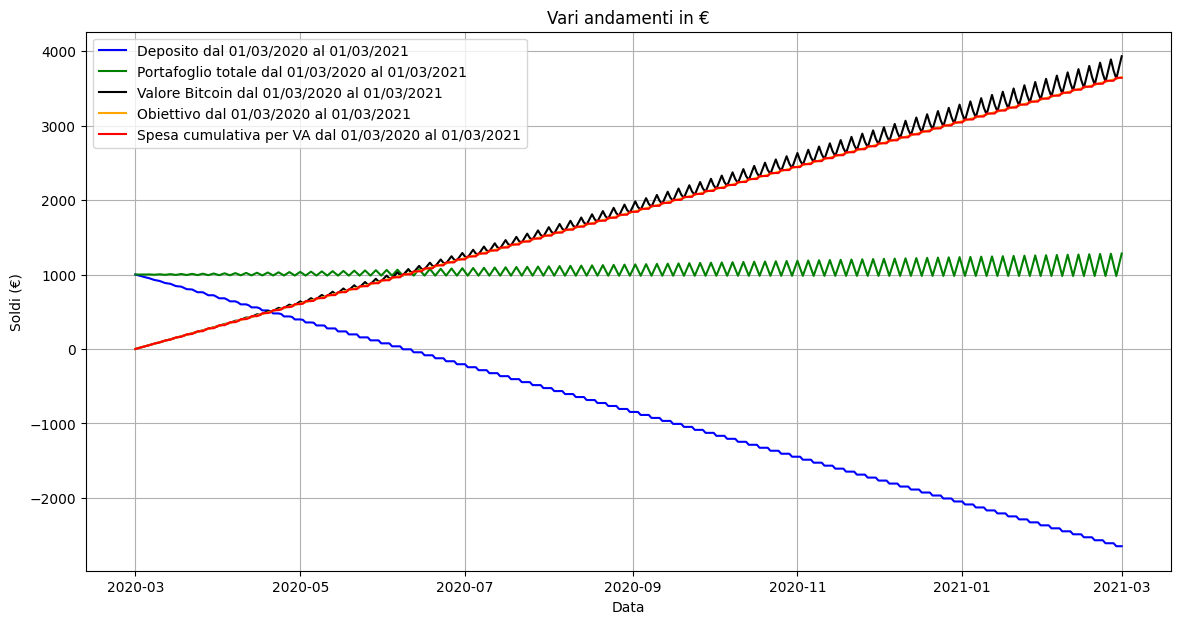

In [69]:
x = dati['Timestamp']
y = tabella_finale['Deposito su YP + liquidità cumulativa in €']
z = tabella_finale['Prezzo bitcoin in €']
w = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €']
h = tabella_finale['Ritiro per strategia Giacomo in €']
j = tabella_finale['Bitcoin su YP in €']
k = tabella_finale['Liquidità cumulativa']
l = tabella_finale['Obiettivo "cumulativo"']
m = tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in €']
n = tabella_finale['Ricarica cumulativa per VA']
plt.figure(figsize=(14, 7))
# plt.plot(x, y, label=f"Deposito su YP + liquidità cumulativa dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='blue')
# plt.plot(x, z, label=f"Prezzo bitcoin dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='yellow')
# plt.plot(x, w, label=f"Deposito + bitcoin su YP + liquidità cumulativa dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='green')
# # plt.plot(x, h, label=f"Ritiro per strategia Giacomo dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='pink')
# plt.plot(x, j, label=f"Bitcoin su YP dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='black')
# # plt.plot(x, k, label=f"Liquidità cumulativa dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='purple')
# plt.plot(x, l, label=f"Obiettivo \"cumulativo\" dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='orange')
# # plt.plot(x, m, label=f"Obiettivo \"cumulativo\" - bitcoin su YP dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='brown')
# plt.plot(x, n, label=f"Ricarica cumulativa per VA dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='red')
plt.plot(x, y, label=f"Deposito dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='blue')
# plt.plot(x, z, label=f"Prezzo bitcoin dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='yellow')
plt.plot(x, w, label=f"Portafoglio totale dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='green')
# plt.plot(x, h, label=f"Ritiro per strategia Giacomo dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='pink')
plt.plot(x, j, label=f"Valore Bitcoin dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='black')
# plt.plot(x, k, label=f"Liquidità cumulativa dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='purple')
plt.plot(x, l, label=f"Obiettivo dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='orange')
# plt.plot(x, m, label=f"Obiettivo \"cumulativo\" - bitcoin su YP dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='brown')
plt.plot(x, n, label=f"Spesa cumulativa per VA dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='red')
plt.title('Vari andamenti in €')
plt.xlabel('Data')
plt.ylabel('Soldi (€)')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
(10*60+20*59+90*58)/120

58.333333333333336

<h6> Grafico della quantità di Bitcoin (numericamente) </h6>

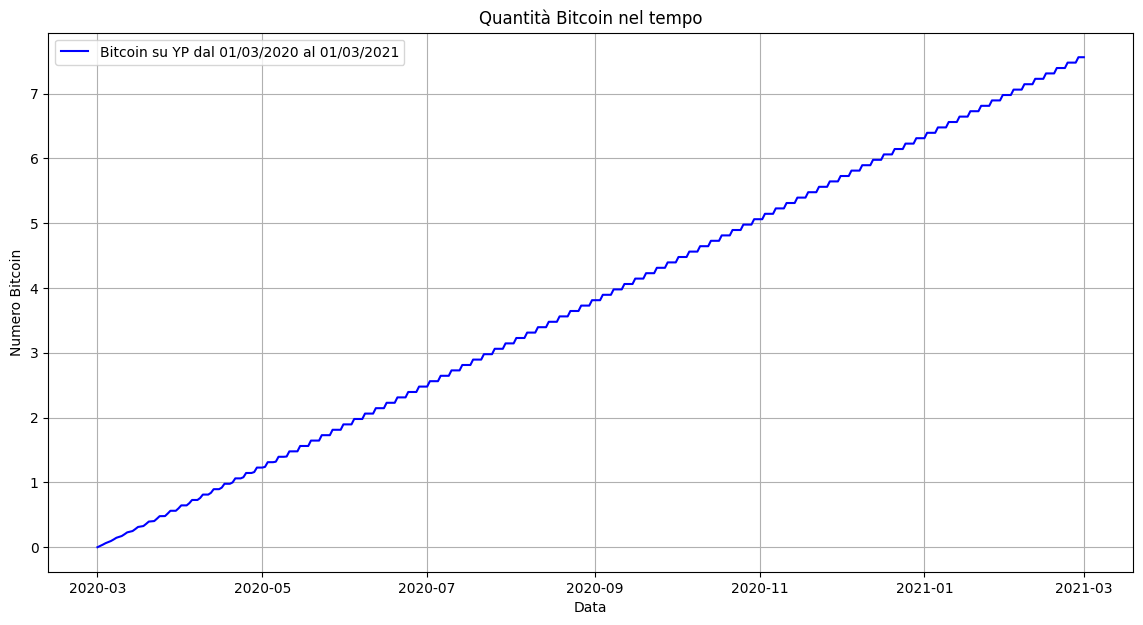

In [67]:
x = dati['Timestamp']
y = tabella_finale['Bitcoin su YP']
plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"Bitcoin su YP dal {str(x.iloc[0].strftime('%d/%m/%Y'))} al {str(x.iloc[-1].strftime('%d/%m/%Y'))}", color='blue')
plt.title('Quantità Bitcoin nel tempo')
plt.xlabel('Data')
plt.ylabel('Numero Bitcoin')
plt.legend()
plt.grid(True)
plt.show()

### Random search

In [ ]:
dati = pd.read_csv('bitcoin_data.csv')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])

In [ ]:
data_inizio = '2020-02-01'
data_fine = '2021-11-01'

In [ ]:
data1 = datetime.strptime(data_inizio, '%Y-%m-%d')
data2 = datetime.strptime(data_fine, '%Y-%m-%d')
lunghezza_periodo = (data2-data1).days
lunghezza_periodo

In [ ]:
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]

In [ ]:
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]

In [ ]:
dati = dati[indice_inizio:indice_fine + 1]

In [ ]:
dati = dati.reset_index(drop=True)

In [ ]:
colonne = ['Data inizio', 'Data fine', 'Lunghezza periodo (giorni)', 'Soldi in banca iniziali (€)', 'Deposito iniziale (€)', 'Investimento base', 'Strategia Giacomo', 'Percentuale ritiro eccesso', 'Tempo controllo', 'Strategia VA', 'Vendita VA', 'Prima VA', 'Tempo acquisto VA', 'Quantità VA', 'Liquidità cumulativa finale', 'Ricarica cumulativa finale', 'Deposito finale (€)', 'Deposito + liquidità cumulativa finali (€)', 'Bitcoin finali', 'Bitcoin finali (€)', 'Deposito + bitcoin + liquidità cumulativa finali (€)', 'Max delta neg su deposito + liquidità (€)', 'Max delta pos su deposito + liquidità (€)', 'Tasse pagate', 'Guadagno finale su deposito + bitcoin + liquidità cumulativa (€)', 'Guadagno / max_delta_neg', 'Guadagno - max_delta_neg']
# Creo un DataFrame vuoto con le colonne specificate
risultati = pd.DataFrame(columns=colonne)

In [ ]:
combinazioni = 1000

In [ ]:
def bitcoin_in_dollari(bitcoin, prezzo_bitcoin):
                return bitcoin * prezzo_bitcoin

def dollari_in_bitcoin(dollari, prezzo_bitcoin):
                return dollari / prezzo_bitcoin

<h6> Cuore della random search </h6>

In [ ]:
tabella_finale = dati.copy()
tabella_finale.rename(columns={'Timestamp': 'Data'}, inplace=True)
tabella_finale.rename(columns={'Price': 'Prezzo bitcoin in €'}, inplace=True)
tabella_finale['Deposito su YP + liquidità cumulativa in €'] = 0
tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'] = 0

lista_risultati = []


for conta in range(combinazioni):
        print(f'Mi sto occupando della combinazione {conta+1}/{combinazioni}...')
        dollari_in_banca = 100000
        deposito_YP = 0
        deposito_iniziale = 1000
        bitcoin_YP = 0
        bitcoin_YP_in_dollari = 0
        perc_tassa_acquisto = 0.002
        prezzo_attuale = tabella_finale['Prezzo bitcoin in €'][0]



        # Variabili
        investimento_base = random.randint(deposito_iniziale, deposito_iniziale) # Quanti € di bitcoin compro il primo giorno; è anche la soglia per sapere se ritirare l'eccesso dei soldi
        liquidità_cumulativa = 0
        ricarica_cumulativa = 0
        # tasse_pagate_ist = 0
        tasse_pagate = 0
        strategia_giacomo = random.choice([True, True])
        strategia_VA = random.choice([False, False])

        while not strategia_giacomo and not strategia_VA:
                strategia_giacomo = random.choice([True, False])
                strategia_VA = random.choice([True, False])
        
        if strategia_giacomo:
                perc_ritiro = round(1, 2) # random.randint(9*10**15, 10**16)/10**16
                tempo_controllo = random.randint(lunghezza_periodo-9, lunghezza_periodo) # Ogni quanti giorni controllo se c'è da ritirare l'eccesso dei soldi rispetto all'investimento_base

        else:
                perc_ritiro = '-'
                tempo_controllo = '-'
        
        if strategia_VA:
                timeframe = random.randint(1, 1) # Ogni quanti giorni faccio in modo di comprare (o eventualmente vendere se vendita_VA = True) bitcoin in modo che il totale valga quanto stabilito dall'obiettivo di quel giorno (ad esempio potrei avere come obiettivo il secondo giorno 200€, il terzo giorno 300€ e così via)
                quantità_VA = random.randint(deposito_iniziale, deposito_iniziale) # ogni timeframe giorni compro bitcoin in € pari al valore che serve per avere quantità_VA € in più rispetto alla volta precedente (in particolare timeframe giorni prima); quindi inizialmente ho bitcion con valore quantità_VA €, poi timeframe giorni dopo ne avrò in modo che valgano 2*quantità_VA €, poi timeframe dopo avrò 3*quantità_VA € e così via
                vendita_VA = random.choice([True, False]) # se è True, significa che è possibile anche che si venda nel caso in cui il valore obiettivo del portafoglio di quel giorno debba essere inferiore a quello che in realtà ho già; se invece è False, in un caso del genere non si fa niente
        else:
                timeframe = '-'
                quantità_VA = '-'
                vendita_VA = '-'
                # ricarica_cumulativa = '-'
                # liquidità_cumulativa = '-'

        if strategia_VA and strategia_giacomo:
                fare_prima_VA = random.choice([True, False]) # se è True, viene fatto prima (eventualmente) il value averaging e poi si ritira (eventualmente) la differenza tra i dollari posseduti su YP e l'investimento iniziale, altrimenti viceversa
        else:
                fare_prima_VA = '-'





        # Ricarica iniziale del deposito di YP
        dollari_in_banca -= deposito_iniziale
        deposito_YP += deposito_iniziale

        # Acquisto bitcoin su YP per la prima volta, prima di cominciare il ciclo con le mie strategie
        deposito_YP -= investimento_base * (1 + perc_tassa_acquisto)
        bitcoin_YP += dollari_in_bitcoin(investimento_base, prezzo_attuale)
        # print('Prezzo attuale:', prezzo_attuale)
        # print('bitcoin_YP', bitcoin_YP)
        bitcoin_YP_in_dollari += investimento_base
        # tasse_pagate_ist = perc_tassa_acquisto * investimento_base
        tasse_pagate += perc_tassa_acquisto * investimento_base

        tabella_finale['Deposito su YP + liquidità cumulativa in €'][0] = deposito_YP + liquidità_cumulativa
        tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][0] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa



        # tabella_finale['Deposito su YP in €'] = 0
        # tabella_finale['Bitcoin su YP'] = 0
        # tabella_finale['Bitcoin su YP in €'] = 0
        # tabella_finale['Ritiro per strategia Giacomo in €'] = 0
        # tabella_finale['Soldi in banca in €'] = dollari_in_banca
        # tabella_finale['Vendita effettuata'] = False
        # tabella_finale['Liquidità istantanea'] = 0
        # tabella_finale['Liquidità cumulativa'] = 0
        # tabella_finale['Obiettivo'] = 0 # La popolo successivamente
        # tabella_finale['Ricarica istantanea per VA'] = 0
        # tabella_finale['Ricarica cumulativa per VA'] = 0


        # Inizio del calcolo vero e proprio
        for t in range(1, len(dati)):
                # print(tasse_pagate)
                # liquidità_ist = 0
                prezzo_attuale = tabella_finale['Prezzo bitcoin in €'][t]
                # print('Prezzo attuale:', prezzo_attuale)
                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                # print(bitcoin_YP_in_dollari)


                if fare_prima_VA != '-' and fare_prima_VA:
                        if timeframe != '-' and t % timeframe == 0 and strategia_VA != '-' and strategia_VA: # Se è un giorno in cui voglio comprare altri bitcoin
                                obiettivo = quantità_VA * t // timeframe
                                ricarica = obiettivo - bitcoin_YP_in_dollari
                                liquidità = quantità_VA - ricarica
                                if liquidità >= 0 and liquidità <= quantità_VA:
                                        if deposito_YP >= liquidità: # correzzione aggiunta tardi
                                                deposito_YP -= liquidità
                                                liquidità_cumulativa += liquidità
                                elif liquidità > quantità_VA:
                                        if deposito_YP >= quantità_VA: # correzzione aggiunta tardi
                                                deposito_YP -= quantità_VA
                                                liquidità_cumulativa += quantità_VA
                                # Questo else è superfluo perchè il fondo liquidità è già 0 di base, inoltre aggiungere 0 è come non fare nulla, ma lo lascio per chiarezza
                                # else:
                                #         # liquidità_ist = 0
                                #         liquidità_cumulativa += 0


                                if ricarica >= 0:
                                        # Se non ci sono abbastanza soldi nel deposito, prendo tutto dal deposito e quello che manca dalla liquidità accumulata
                                        if ricarica * (1 + perc_tassa_acquisto) <= deposito_YP:
                                                deposito_YP -= ricarica * (1 + perc_tassa_acquisto)
                                                # tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                                # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                                tasse_pagate += perc_tassa_acquisto * ricarica
                                        else:
                                                liquidità_cumulativa -= ricarica * (1 + perc_tassa_acquisto) - deposito_YP
                                                deposito_YP = 0
                                                # tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                                # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                                tasse_pagate += perc_tassa_acquisto * ricarica
                                        bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale)
                                        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                                        ricarica_cumulativa += ricarica
                                        # tabella_finale['Ricarica istantanea per VA'][t] = ricarica
                                elif vendita_VA:
                                        # tabella_finale['Vendita effettuata'][t] = True
                                        deposito_YP -= ricarica * (1 - perc_tassa_acquisto) # aumenta il deposito perchè qui ricarica è negativa; poi ci sono le tasse anche sulla vendita
                                        # tasse_pagate_ist = -perc_tassa_acquisto * ricarica
                                        # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate -= perc_tassa_acquisto * ricarica # anche qui è importante ricordare il "-" perchè ricarica è negativa
                                        bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale) # calano perchè qui ricarica è negativa
                                        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                                # tabella_finale['Obiettivo'][t] = obiettivo


                        if tempo_controllo!='-' and t % tempo_controllo == 0 and strategia_giacomo!='-' and strategia_giacomo:
                                if bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) > investimento_base:
                                        ritiro_in_dollari = (bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) - investimento_base) * perc_ritiro
                                        # tabella_finale['Ritiro per strategia Giacomo in €'][t] = ritiro_in_dollari
                                        deposito_YP += ritiro_in_dollari * (1 - perc_tassa_acquisto)
                                        # tasse_pagate_ist = perc_tassa_acquisto * ritiro_in_dollari
                                        # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ritiro_in_dollari
                                        bitcoin_YP -= dollari_in_bitcoin(ritiro_in_dollari, prezzo_attuale)
                                        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                else:

                        if tempo_controllo!='-' and t % tempo_controllo == 0 and strategia_giacomo!='-' and strategia_giacomo:
                                if bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) > investimento_base:
                                        ritiro_in_dollari = (bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) - investimento_base) * perc_ritiro
                                        # tabella_finale['Ritiro per strategia Giacomo in €'][t] = ritiro_in_dollari
                                        deposito_YP += ritiro_in_dollari * (1 - perc_tassa_acquisto)
                                        # tasse_pagate_ist = perc_tassa_acquisto * ritiro_in_dollari
                                        # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ritiro_in_dollari
                                        bitcoin_YP -= dollari_in_bitcoin(ritiro_in_dollari, prezzo_attuale)
                                        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)


                        if timeframe != '-' and t % timeframe == 0 and strategia_VA != '-' and strategia_VA: # Se è un giorno in cui voglio comprare altri bitcoin
                                obiettivo = quantità_VA * t // timeframe
                                # print('Obiettivo:', obiettivo)
                                ricarica = obiettivo - bitcoin_YP_in_dollari
                                # print('Ricarica:', ricarica)
                                # print('Bitcoin YP', bitcoin_YP)
                                # print('Bitcoin YP in €', bitcoin_YP_in_dollari)
                                liquidità = quantità_VA - ricarica
                                if liquidità >= 0 and liquidità <= quantità_VA:
                                        if deposito_YP >= liquidità: # correzzione aggiunta tardi
                                                deposito_YP -= liquidità
                                                liquidità_cumulativa += liquidità
                                elif liquidità > quantità_VA:
                                        if deposito_YP >= quantità_VA: # correzzione aggiunta tardi
                                                deposito_YP -= quantità_VA
                                                liquidità_cumulativa += quantità_VA
                                # Questo else è superfluo perchè il fondo liquidità è già 0 di base, inoltre aggiungere 0 è come non fare nulla, ma lo lascio per chiarezza
                                # else:
                                #         # liquidità_ist = 0
                                #         liquidità_cumulativa += 0
                                        

                                if ricarica >= 0:
                                        # Se non ci sono abbastanza soldi nel deposito, prendo tutto dal deposito e quello che manca dalla liquidità accumulata
                                        if ricarica * (1 + perc_tassa_acquisto) <= deposito_YP:
                                                deposito_YP -= ricarica * (1 + perc_tassa_acquisto)
                                                # tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                                # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                                tasse_pagate += perc_tassa_acquisto * ricarica
                                        else:
                                                liquidità_cumulativa -= ricarica * (1 + perc_tassa_acquisto) - deposito_YP
                                                deposito_YP = 0
                                                # tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                                # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                                tasse_pagate += perc_tassa_acquisto * ricarica
                                        bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale)
                                        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                                        ricarica_cumulativa += ricarica
                                        # tabella_finale['Ricarica istantanea per VA'][t] = ricarica
                                elif vendita_VA:
                                        # tabella_finale['Vendita effettuata'][t] = True
                                        deposito_YP -= ricarica * (1 - perc_tassa_acquisto) # aumenta il deposito perchè qui ricarica è negativa; poi ci sono le tasse anche sulla vendita
                                        # tasse_pagate_ist = -perc_tassa_acquisto * ricarica
                                        # tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate -= perc_tassa_acquisto * ricarica # anche qui è importante ricordare il "-" perchè ricarica è negativa
                                        bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale) # calano perchè qui ricarica è negativa
                                        bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                                # tabella_finale['Obiettivo'][t] = obiettivo
                                        
                # tabella_finale['Deposito su YP in €'][t] = deposito_YP
                tabella_finale['Deposito su YP + liquidità cumulativa in €'][t] = deposito_YP + liquidità_cumulativa
                # tabella_finale['Bitcoin su YP'][t] = bitcoin_YP
                # tabella_finale['Bitcoin su YP in €'][t] = bitcoin_YP_in_dollari
                # tabella_finale['Liquidità istantanea'][t] = liquidità_ist
                # tabella_finale['Liquidità cumulativa'][t] = liquidità_cumulativa
                tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][t] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
                # tabella_finale['Ricarica cumulativa per VA'][t] = ricarica_cumulativa



        # Analisi post calcolo
        max_delta_neg = 0
        max_delta_pos = 0
        guadagno_finale = 0



        # ind_neg = 'Nessuno'
        # ind_pos = 'Nessuno'

        for index, i in enumerate(tabella_finale['Deposito su YP + liquidità cumulativa in €']):
                if deposito_iniziale - i > max_delta_neg:
                        max_delta_neg = deposito_iniziale - i
                        # ind_neg = index

                if i - deposito_iniziale > max_delta_pos:
                        max_delta_pos = i - deposito_iniziale
                        # ind_pos = index



        guadagno_finale = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][len(tabella_finale) - 1] - tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in €'][0]


        # Popolo la tabella dei risultati
        nuovi_dati = [data_inizio, data_fine, lunghezza_periodo, dollari_in_banca, deposito_iniziale, investimento_base, strategia_giacomo, perc_ritiro, tempo_controllo, strategia_VA, vendita_VA, fare_prima_VA, timeframe, quantità_VA, liquidità_cumulativa, ricarica_cumulativa, deposito_YP, deposito_YP + liquidità_cumulativa, bitcoin_YP, bitcoin_YP_in_dollari, deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa, max_delta_neg, max_delta_pos, tasse_pagate, guadagno_finale, guadagno_finale / max_delta_neg, guadagno_finale - max_delta_neg]

        # risultati = risultati.append(pd.Series(nuovi_dati, index=colonne), ignore_index=True)

        # In futuro dovrei essere costretto a usare il codice qui sotto al posto di append, ma provando ho notato che è molto più lento
        # nuova_serie = pd.Series(nuovi_dati, index=colonne)
        # risultati = pd.concat([risultati, nuova_serie], ignore_index=True)

        # aggiungi i tuoi dati alla lista come dizionari
        lista_risultati.append(dict(zip(colonne, nuovi_dati)))
        # alla fine, crea un DataFrame
        
risultati = pd.DataFrame(lista_risultati)

<h6> Tabelle </h6>

In [ ]:
risultati

In [ ]:
# Ordino la tabella in base al guadagno finale
ordine1 = risultati.sort_values(by='Guadagno finale su deposito + bitcoin + liquidità cumulativa (€)', ascending=False)
ordine1

In [ ]:
ordine3 = risultati.sort_values(by='Guadagno - max_delta_neg', ascending=False)
ordine3

In [ ]:
soglia = deposito_iniziale
risultati_con_investimenti_sotto_soglia = risultati[risultati['Max delta neg su deposito + liquidità (€)'] <= soglia]
risultati_con_investimenti_sotto_soglia

In [ ]:
risultati_con_investimenti_sotto_soglia.sort_values(by='Guadagno finale su deposito + bitcoin + liquidità cumulativa (€)', ascending = False)

In [ ]:
risultati_con_investimenti_sotto_soglia.sort_values(by='Guadagno - max_delta_neg', ascending = False)

In [ ]:
counter = 1
percorso_output = r'C:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Giochi e simulazioni\Simulazioni\Simulatore di compravendita\Analisi Bitcoin\Risultati analisi strategie di compravendita con correzione'
existing_dirs = os.listdir(percorso_output)
# Conto quanti csv ci sono già per sapere che nome dare al prossimo
while any(name.startswith(f"Risultati_{counter}") for name in existing_dirs):
    counter += 1

In [ ]:
# Esporto la tabella risultati
risultati.to_csv(f'Risultati analisi strategie di compravendita con correzione/Risultati_{counter}.csv', index = False)

### Leggo e concateno più file csv

In [ ]:
def concatena_csv(percorso):
    # Ottieni tutti i file nel percorso specificato
    files = [f for f in os.listdir(percorso) if f.endswith('.csv') and f.startswith('Risultati')]

    # Crea una lista vuota per contenere i dati
    dati = []

    # Leggi ogni file CSV e aggiungilo alla lista
    for file in files:
        dati.append(pd.read_csv(os.path.join(percorso, file)))

    # Concatena tutti i dataframe
    risultati_concatenati = pd.concat(dati, ignore_index=True)

    return risultati_concatenati

# Utilizza la funzione
risultati_concatenati = concatena_csv(percorso_output)
risultati_concatenati

In [ ]:
risultati_concatenati.sort_values(by='Guadagno - max_delta_neg', ascending = False)

In [ ]:
soglia = deposito_iniziale
risultati_concatenati_con_investimenti_sotto_soglia = risultati_concatenati[risultati_concatenati['Max delta neg su deposito + liquidità (€)'] <= soglia]
risultati_concatenati_con_investimenti_sotto_soglia

In [ ]:
risultati_concatenati_con_investimenti_sotto_soglia.sort_values(by='Guadagno - max_delta_neg', ascending = False)

In [ ]:
risultati_concatenati_con_investimenti_sotto_soglia[risultati_concatenati_con_investimenti_sotto_soglia['Guadagno - max_delta_neg']>2400].sort_values(by='Guadagno - max_delta_neg', ascending = False)

<h6> Deduplico i risultati concatenati </h6>

In [ ]:
risultati_deduplicati = risultati_concatenati.drop_duplicates()
risultati_deduplicati

In [ ]:
deduplicati_ordinati = risultati_deduplicati.sort_values(by='Guadagno - max_delta_neg', ascending = False)
deduplicati_ordinati

In [ ]:
deduplicati_ordinati[deduplicati_ordinati['Strategia Giacomo'] == False]

In [ ]:
deposito_iniziale

In [ ]:
soglia = deposito_iniziale
deduplicati_ordinati_con_investimenti_sotto_soglia = deduplicati_ordinati[deduplicati_ordinati['Max delta neg su deposito + liquidità (€)'] <= soglia]
deduplicati_ordinati_con_investimenti_sotto_soglia

In [ ]:
deduplicati_ordinati_con_investimenti_sotto_soglia[deduplicati_ordinati_con_investimenti_sotto_soglia['Strategia Giacomo'] == False]

In [ ]:
deduplicati_ordinati_con_investimenti_sotto_soglia[deduplicati_ordinati_con_investimenti_sotto_soglia['Investimento base'] == 0]

<h6> Esporto i risultati </h6>

In [ ]:
# Esporto i deduplicati_ordinati_con_investimenti_sotto_soglia in csv
# deduplicati_ordinati_con_investimenti_sotto_soglia.to_csv(f'Risultati con max_delta_neg su deposito + liquidità sotto {soglia} (periodo {data_inizio}-{data_fine}).csv', index=False)

In [ ]:
# Esporto i risultati concatenati in csv
# deduplicati_ordinati.to_csv(f'Risultati concatenati deduplicati (periodo {data_inizio}-{data_fine}) 2.csv', index=False)